In [75]:
import numpy as np
import subprocess
import os
from multiprocessing import Pool

import matplotlib.pyplot as plt

%matplotlib inline

In [47]:
WORK_DIR = 'temp_folders/'

In [49]:
elements = {
    'GA': {
        'interactivity': 2.5e-4,
        'moment': 7.29*9.27e-24
    }
}

In [139]:
class Config:
    
    def __init__(self, temperature, field, element, saved_data_samples, exper_name):
        self.args = {}
        self.args['temperature'] = temperature
        self.args['field'] = field
        self.args['interactivity'] = elements[element]['interactivity']
        self.args['magnetic_moment'] = elements[element]['moment']
        self.args['saved_data_samples'] = saved_data_samples
        self.element = element
        self.name = '_'.join([exper_name, element, str(int(self.args['temperature'])), str(int(self.args['field']))])
        
    def dump_config(self, path):
        
        full_path = os.path.join(path, self.name+'.conf')
        
        with open(full_path, 'w+') as f:
            f.write( "\n".join( map(lambda x: x[0]+' '+str(x[1]), self.args.items() ) ) )
            
        return full_path

In [131]:
def run_experiment(temp, field, element, step_iterations, exper_name):
    
    '''
    temp, field: (start, end, num_iter) - (n, n+1, 1) if you want just one value
    step_iterations: how many metropolis walks to make for each value pairs
    '''
    
    for curr_temp in np.linspace(temp[0], temp[1], temp[2]):
        for curr_field in np.linspace(field[0], field[1], field[2]):
            
            conf = Config(
                temperature = curr_temp,
                field = curr_field,
                element = element,
                saved_data_samples=150,
                exper_name = exper_name
            )
            
            conf_path = conf.dump_config(os.path.join(WORK_DIR, 'configs'))
            get_save = lambda x: os.path.join(WORK_DIR, 'results', conf.name+'_'+str(x)+'.npy')
            
            for i in range(step_iterations):
                subprocess.run(['model/model', conf_path, get_save(i)])
    
    print('Experiment', exper_name, 'is done')

In [145]:
def split_range(ran, n_proc):
    
    '''
    ran: (start, stop, num_iter) - (n, n+1, 1) if you want just one value
    '''
    
    if (ran[1] - ran[0]) == 1 and ran[2] == 1:
        return [ran] * n_proc
    
    assert (ran[2] % n_proc) == 0, 'Please choose a divisible number'
    
    ranges = []
    step = ran[2] / n_proc
    step_val = (ran[1] - ran[0]) / ran[2]
    
    for i in range( n_proc ):
        ranges.append( [ran[0] + i*step*step_val, ran[0] + (i+1)*step*step_val, step] )
    
    return ranges

In [175]:
def make_par_args(args, n_proc):
    
    par_args = args.copy() 
    
    for i, x in enumerate(args):
        if type(args[i]) is not type([]) or len(args[i]) != n_proc:
            par_args[i] = [par_args[i]] * n_proc

    return list(zip(*par_args))

In [138]:
run_experiment([5, 6, 1], [0, 1, 1], 'GA', 1, 'TEST')

Experiment TEST is done


# Check stabilization

In [ ]:
%%time

N_PROC = 1

with Pool(processes=N_PROC) as pool:
    
    temp_range = [1, 6, 5]
    temp_ranges = split_range(temp_range, N_PROC)
    field_range = [0, 1, 1]
    element = 'GA'
    step_iterations = 2
    exper_name = "STAB2"
    
    args = make_par_args( [temp_ranges, field_range, element, step_iterations, exper_name], N_PROC )
    
    pool.starmap(run_experiment, args)

/home/max/Libs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [181]:
np.load('temp_folders/results/STAB_GA_4_0_0.npy')[-1]

array([-1.05192382e-24, -4.89101000e+02])

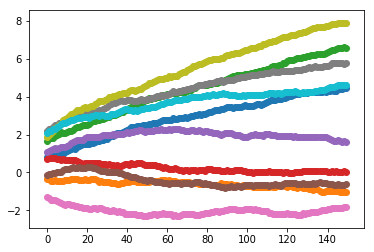

In [197]:
dat = []

for file in os.listdir('temp_folders/results/'):
    if 'STAB_GA' in file:
        res = np.load('temp_folders/results/'+file)
        plt.scatter(np.arange(res.shape[0]), res[:,0]*1e24)
        dat.append([float(file.split('_')[2]), res[-1][0]])
        
dat = np.array(dat)

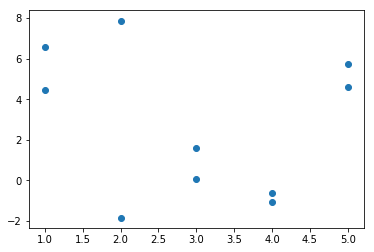

In [191]:
plt.scatter(dat[:, 0], dat[:, 1] * 1e24)

# Curie temperature 

In [43]:
arguments = [["1000", "4"], ["1100", "5"]]

def run_curie(temp, field, experiment_num):
    subprocess.run(['model/model', temp, field, os.path.join('res', temp+'_'+field+'_'+str(experiment_num))+'.npy'])

In [41]:
with Pool(processes=5)

Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/max/Libs/anaconda3/lib/python3.7/multiprocessing/process.p

In [42]:
pool.starmap(run_curie, [["1000", "4", 0], ["1100", "5", 0]])

[None, None]

In [140]:
results = np.load('temp_folders/results/TEST_GA_5.0_0.0_0.npy')

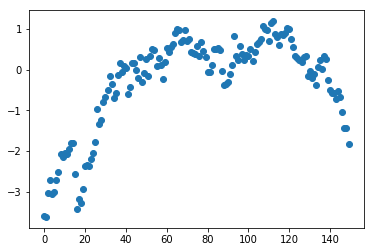

In [141]:
plt.scatter(np.arange(results[:, 0].shape[0]), results[:, 0]*1e25)

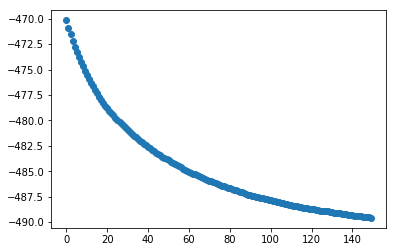

In [142]:
plt.scatter(np.arange(results[:, 0].shape[0]), results[:, 1])